In [14]:
import pandas as pd
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import re
from string import punctuation
import pymorphy2
import numpy as np
from scipy.linalg import eigh
import nltk
import torch
import pickle
import matplotlib.pyplot as plt
import torchmetrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from navec import Navec
from razdel import tokenize
# from fasttext.util import download_model
# import fasttext
from gensim.models import Word2Vec


In [15]:
rus_stop_words = stopwords.words("russian")
symbols = list(punctuation) + ['\t', '\n', '\r',
                               '№', '#', '@', '^', '%', '*', '»', '«', '×', 'ń', '√', 'а́']
emojy = [
    '\xeb',
    '\ufffc',
    '\xbf',
    '\u2011',
    '\u200b',
    '\u203c'
]
morph = pymorphy2.MorphAnalyzer(lang='ru')


In [16]:
emoj = re.compile('['
                  u'\U0001F600-\U0001F64F'
                  u'\U0001F300-\U0001F5FF'
                  u'\U0001F680-\U0001F6FF'
                  u'\U0001F1E0-\U0001F1FF'
                  u'\U00002500-\U00002BEF'
                  u'\U00002702-\U000027B0'
                  u'\U000024C2-\U0001F251'
                  u'\U0001f926-\U0001f937'
                  u'\U00010000-\U0010ffff'
                  u'\u2640-\u2642'
                  u'\u2600-\u2B55'
                  u'\u200d'
                  u'\u23cf'
                  u'\u23e9'
                  u'\u231a'
                  u'\ufe0f'
                  u'\u3030'']+||(\S+@\S+\.\S+)||([+]*[(]{0,1}[0-9]{1,4}[)]{0,1}[-\s\./0-9]*)', re.UNICODE)


# Task 1
Загрузите датасет из ЛР1. Датасет большой, рекомендуется для работы взять его часть (далее - корпус).

In [17]:
df = pd.read_csv('../Data/Petitions.csv')
df.head()

,id,public_petition_text,reason_category
0,3168490,снег на дороге,Благоустройство
1,3219678,очистить кабельный киоск от рекламы,Благоустройство
2,2963920,"Просим убрать все деревья и кустарники, которы...",Благоустройство
3,3374910,Неудовлетворительное состояние парадной - надп...,Содержание МКД
4,3336285,Граффити,Благоустройство


# Task 2
Рассмотрите каждый объект корпуса как отдельный текстовый документ. Выполните предварительную обработку каждого объекта.

In [18]:
def filter_fun(text):
    is_not_symbol = True
    for i in text:
        if i in symbols:
            is_not_symbol = False
    is_not_num = not bool(re.match('\d+', text))
    is_not_stop_word = not text in rus_stop_words
    return is_not_num and is_not_symbol and is_not_stop_word


In [19]:
def text_preprocessed(text: str):
    text = text.lower()
    for i in emojy:
        text = text.replace(i, '')
    text = list(map(lambda a: a.text, tokenize(text)))
    text = list(filter(filter_fun, text))
    text = [re.sub(emoj, '', msg) for msg in text]
    text = list(map(lambda i: morph.parse(i)[0].normal_form, text))
    return ' '.join(text)


In [20]:
df['public_petition_text_modded'] = df['public_petition_text'].apply(text_preprocessed)


In [21]:
df.head()

,id,public_petition_text,reason_category,public_petition_text_modded
0,3168490,снег на дороге,Благоустройство,снег дорога
1,3219678,очистить кабельный киоск от рекламы,Благоустройство,очистить кабельный киоск реклама
2,2963920,"Просим убрать все деревья и кустарники, которы...",Благоустройство,просить убрать дерево кустарник который выйти ...
3,3374910,Неудовлетворительное состояние парадной - надп...,Содержание МКД,неудовлетворительный состояние парадный надпис...
4,3336285,Граффити,Благоустройство,граффити


In [22]:
# df.to_csv('../Data/modded_normed_texts.csv', index=False)

# Task 3
Выполните векторизацию каждого документа любым способом (можно с помощью своих моделей Word2Vec, при условии, что Word2Vec модели обучались на той же выборке документов; можно использовать другие библиотеки и модели).

In [23]:
df_t3 = pd.read_csv('../Data/modded_normed_texts.csv').dropna()
df_t3.head()


,id,public_petition_text,reason_category,public_petition_text_modded
0,3168490,снег на дороге,Благоустройство,снег дорога
1,3219678,очистить кабельный киоск от рекламы,Благоустройство,очистить кабельный киоск реклама
2,2963920,"Просим убрать все деревья и кустарники, которы...",Благоустройство,просить убрать дерево кустарник который выйти ...
3,3374910,Неудовлетворительное состояние парадной - надп...,Содержание МКД,неудовлетворительный состояние парадный надпис...
4,3336285,Граффити,Благоустройство,граффити


In [24]:
texts = df_t3['public_petition_text_modded'].apply(lambda a: a.split(' '))
texts


0                                           [снег, дорога]
1                    [очистить, кабельный, киоск, реклама]
2        [просить, убрать, дерево, кустарник, который, ...
3        [неудовлетворительный, состояние, парадный, на...
4                                               [граффити]
                               ...                        
59884                       [просить, закрасить, граффити]
59885      [просить, отремонтировать, пешеходный, дорожка]
59886    [необходимо, демонтировать, незаконный, реклам...
59887    [очень, греметь, ветер, металлический, часть, ...
59888    [два, проблема, один, незаконный, надпись, объ...
Name: public_petition_text_modded, Length: 59888, dtype: object

In [25]:
w2v = Word2Vec(sentences=texts.to_list(), min_count=1, vector_size=128, epochs=128)


In [26]:
# ft = fasttext.train_unsupervised('all_messages_text.txt', model='skipgram', dim=128)

In [40]:
# w2v.save('../Models/W@VLib.bin')

# Task 4 
Закодируйте значения целевого признака (категория обращения). Разделите данные на обучающую и тестирующую выборку.

In [41]:
w2v = Word2Vec.load('../Models/W@VLib.bin')


In [27]:
df_t4 = pd.read_csv('../Data/modded_normed_texts.csv').dropna()
df_t4.head()


,id,public_petition_text,reason_category,public_petition_text_modded
0,3168490,снег на дороге,Благоустройство,снег дорога
1,3219678,очистить кабельный киоск от рекламы,Благоустройство,очистить кабельный киоск реклама
2,2963920,"Просим убрать все деревья и кустарники, которы...",Благоустройство,просить убрать дерево кустарник который выйти ...
3,3374910,Неудовлетворительное состояние парадной - надп...,Содержание МКД,неудовлетворительный состояние парадный надпис...
4,3336285,Граффити,Благоустройство,граффити


In [28]:
with open('../Data/problems_number.pkl', 'wb') as f:
    pickle.dump(dict(enumerate(df_t4['reason_category'].factorize()[1])), f)


In [29]:
with open('../Data/problems_number.pkl', 'rb') as f:
    problems_number = pickle.load(f)


In [30]:
def factorizerProb(id: int):
    v = np.zeros(max(problems_number)+1, dtype=int)
    v[id] = 1
    return v


In [31]:
df_t4['reason_category'] = df_t4['reason_category'].factorize()[0]


In [32]:
df_t4['reason_category2'] = df_t4['reason_category'].apply(factorizerProb)
df_t4.head()


,id,public_petition_text,reason_category,public_petition_text_modded,reason_category2
0,3168490,снег на дороге,0,снег дорога,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,3219678,очистить кабельный киоск от рекламы,0,очистить кабельный киоск реклама,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,2963920,"Просим убрать все деревья и кустарники, которы...",0,просить убрать дерево кустарник который выйти ...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,3374910,Неудовлетворительное состояние парадной - надп...,1,неудовлетворительный состояние парадный надпис...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,3336285,Граффити,0,граффити,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [33]:
c = df_t4.copy(deep=True)
c['reason_category2'] = c['reason_category2'].apply(lambda a: ''.join(map(str, a)))
c.to_csv('../Data/factorize_classes.csv', index=False)

In [34]:
vectored_classes = np.array(df_t4['reason_category2'].to_list())
vectored_classes



array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [35]:
max_sentence_len = df_t4['public_petition_text_modded'].apply(lambda a: len(a.split(' '))).max()
max_sentence_len


239

In [36]:
vectored_sentece_sum = np.array(df_t4['public_petition_text_modded'].apply(lambda a: sum([w2v.wv[i] for i in a.split(' ')])).to_list())
vectored_sentece_sum.shape


(59888, 128)

In [37]:
def make_sentence_matrix(sentence, max_sentence_len, k):
    x = np.array([w2v.wv[i].tolist() for i in sentence.split(' ')])
    y = np.append(x, k * np.ones((max_sentence_len-x.shape[0], x.shape[1])), axis=0)
    return y.tolist()


In [38]:
vectored_classes = np.array(df_t4['reason_category2'].to_list())
vectored_classes


array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [107]:
sentence_matrix = np.array(df_t4['public_petition_text_modded'].apply(lambda a: make_sentence_matrix(a, 239, 1)).tolist()).shape


In [44]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [51]:
X, y = RandomUnderSampler(
    # sampling_strategy='',
    # n_jobs=4
).fit_resample(
    vectored_sentece_sum,
    df_t4['reason_category']
)
X.shape, np.array(pd.Series(y).apply(factorizerProb).to_list()).shape


((3570, 128), (3570, 15))

In [52]:
pd.Series(y).value_counts()


reason_category
0     238
1     238
2     238
3     238
4     238
5     238
6     238
7     238
8     238
9     238
10    238
11    238
12    238
13    238
14    238
Name: count, dtype: int64

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
)


In [60]:
y_train_v = np.array(y_train.apply(factorizerProb).to_list())
y_test_v = np.array(y_test.apply(factorizerProb).to_list())


# Task 5
С помощью PyTorch соберите и обучите три нейронных сети для решения задачи классификации (предсказания категории обращения); количество слоев и значения других параметров конфигурируете по вашему усмотрению:
1) сеть на базе блока RNN;
2) сеть на базе блока LSTM;
3) сеть на базе блока GRU.

In [70]:
class RecExample(torch.nn.Module):
    def __init__(
        self,
        size_of_sample: int,
        num_of_samples: int,
        input_size_of_first_layer: int,
        input_size_of_second_layer: int,
        input_size_of_third_layer: int,
        input_layer_size: int,
        alpha: float = 5
    ):
        
        super(RecExample, self).__init__()
        self.alpha = alpha
        self.input_size_of_first_layer = size_of_sample
        self.output_size_of_first_layer = input_size_of_first_layer
        self.num_layers_of_first_layer = int(num_of_samples / (alpha * (self.input_size_of_first_layer + self.output_size_of_first_layer)))
        self.output_size_of_second_layer = input_size_of_second_layer
        self.output_size_of_third_layer = input_size_of_third_layer
        self.output_layer_size = input_layer_size

        self.input_layer = torch.nn.GRU(
            input_size=self.input_size_of_first_layer,
            hidden_size=self.output_size_of_first_layer,
            num_layers=self.num_layers_of_first_layer
        )

        self.second_layer = torch.nn.Linear(
            in_features=self.output_size_of_first_layer,
            out_features=self.output_size_of_second_layer,
        )
        self.third_layer = torch.nn.Linear(
            in_features=self.output_size_of_second_layer,
            out_features=self.output_size_of_third_layer,
        )
        self.output_layer = torch.nn.Linear(
            in_features=self.output_size_of_third_layer,
            out_features=self.output_layer_size,
        )

        self.input_activation = torch.nn.Tanh()
        self.second_activation = torch.nn.Tanh()
        self.third_activation = torch.nn.Tanh()
        self.h1 = torch.zeros(self.num_layers_of_first_layer, self.output_size_of_first_layer).requires_grad_().double().to('cuda')

    def forward(self, x):
        y, self.h1 = self.input_layer(x, self.h1.detach().to('cuda'))
        y = self.input_activation(y)
        y = self.second_layer(y)
        y = self.second_activation(y)
        y = self.third_layer(y)
        y = self.third_activation(y)
        y = self.output_layer(y)
        return y


In [71]:
ds_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).double(), torch.from_numpy(y_train_v).double())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True)


In [77]:
model = RecExample(
    size_of_sample=X_train.shape[1],
    num_of_samples=X.shape[0],
    input_size_of_first_layer=64,
    input_size_of_second_layer=40,
    input_size_of_third_layer=25,
    input_layer_size=15,
).double().to('cuda')


In [78]:
loss = torch.nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)


In [95]:
# er_list = []
epochs = 200
for epoch in range(epochs):
    for x_b, y_b in dl_train:
        outputs = model(x_b.to('cuda'))
        loss_value = loss(outputs, y_b.to('cuda'))
        loss_value.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
    er_list.append(loss_value.item())
    print(f'Эпоха {epoch + 1}, Значение функции потерь: {loss_value.item()}')


Эпоха 1, Значение функции потерь: 0.29329206450854933
Эпоха 2, Значение функции потерь: 0.2827049006116894
Эпоха 3, Значение функции потерь: 0.28998401393463846
Эпоха 4, Значение функции потерь: 0.278518920781981
Эпоха 5, Значение функции потерь: 0.29332792928097334
Эпоха 6, Значение функции потерь: 0.28307222282980177
Эпоха 7, Значение функции потерь: 0.2805189316474313
Эпоха 8, Значение функции потерь: 0.28826980615850895
Эпоха 9, Значение функции потерь: 0.28428618813734774
Эпоха 10, Значение функции потерь: 0.27579651364143853
Эпоха 11, Значение функции потерь: 0.27383498055120636
Эпоха 12, Значение функции потерь: 0.2698338507950124
Эпоха 13, Значение функции потерь: 0.2721464646568616
Эпоха 14, Значение функции потерь: 0.28056723450179744
Эпоха 15, Значение функции потерь: 0.27887713284860777
Эпоха 16, Значение функции потерь: 0.27165692714815315
Эпоха 17, Значение функции потерь: 0.27442400783497667
Эпоха 18, Значение функции потерь: 0.2731736414848867
Эпоха 19, Значение функции

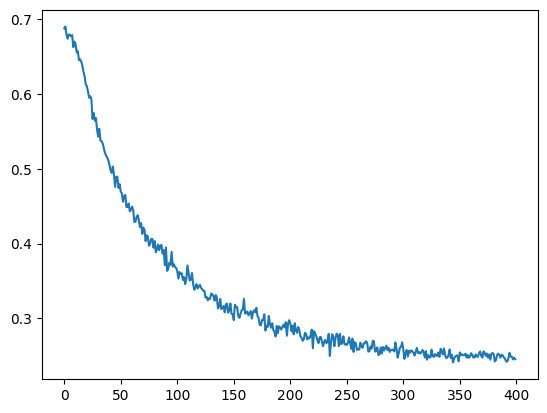

In [96]:
plt.plot(er_list)


# Task 6
Используя известные вам метрики классификации и тестирующую выборку оцените качество каждой из обученных моделей. Сделайте вывод о том, какая из моделей на ваших данных отработала лучше других.

In [97]:
x_t = torch.tensor(X_test).to('cuda').double()
# y_t = torch.tensor(y_test).to('cuda')


In [98]:
torch.save(model, '../Models/Recur.pt')

In [99]:
m = torch.load('../Models/Recur.pt')


In [100]:
pred = model(x_t)


In [101]:
pred


tensor([[-2.4137, -2.6265, -2.5646,  ..., -2.5793, -2.4260, -2.5124],
        [-2.4137, -2.6265, -2.5646,  ..., -2.5793, -2.4260, -2.5124],
        [-2.4137, -2.6265, -2.5646,  ..., -2.5793, -2.4260, -2.5124],
        ...,
        [-2.4137, -2.6265, -2.5645,  ..., -2.5793, -2.4259, -2.5124],
        [-2.4137, -2.6265, -2.5645,  ..., -2.5793, -2.4259, -2.5124],
        [-2.4137, -2.6265, -2.5645,  ..., -2.5793, -2.4260, -2.5124]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [103]:
np.argmax(pred.to('cpu').detach().numpy(), axis=1)


array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [105]:
print(classification_report(np.argmax(pred.to('cpu').detach().numpy(), axis=1), y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      0.08      0.14       357
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0

    accuracy                           0.08       357
   macro avg       0.07      0.01      0.01       357
weighted avg       1.00   

d:\5semak\NLP_5_semak\NLP\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\5semak\NLP_5_semak\NLP\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\5semak\NLP_5_semak\NLP\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Вывод

Чёт как-то оч не оч.